# The Coin Whisperer Project
*USYD FinTech Bootcamp Jul-2023 Group Project 2 - Group 3*

# 1. Setup and Imports

In [1]:
# Libraries and Dependencies
## Base
import pandas as pd
import numpy as np
import time
import os
from pathlib import Path
import hvplot.pandas
import holoviews as hv
import yfinance as yf
from dotenv import load_dotenv
from PIL import Image, ImageDraw, ImageFont

# Machine Learning
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
%matplotlib inline
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from arch import arch_model

## Additional Work
import fear_and_greed
import alpaca_trade_api as tradeapi

# Installs needed for the code
## !pip install yfinance
## !pip install fear_and_greed
## !pip install arch
#pip install selenium

--------------------

# 2. Inputs and Initial Data

In [125]:
load_dotenv()

Python-dotenv could not parse statement starting at line 7


True

In [3]:
# Set the start and end dates
start_date = "2019-04-01"
end_date = "2023-07-10"

# Retrieve the Ethereum data
BTC = yf.Ticker("BTC-USD")
BTC_data = BTC.history(start = start_date, end = end_date)

# Display the DataFrame with hourly data for Ethereum
df_stock = pd.DataFrame(BTC_data)
df_stock.index = pd.to_datetime(df_stock.index, infer_datetime_format=True)
df_stock.index.name = 'date'
df_stock.tail()

Open          High           Low  \
date                                                                  
2023-07-05 00:00:00+00:00  30778.724609  30877.330078  30225.613281   
2023-07-06 00:00:00+00:00  30507.150391  31460.052734  29892.226562   
2023-07-07 00:00:00+00:00  29907.998047  30434.644531  29777.285156   
2023-07-08 00:00:00+00:00  30346.921875  30374.437500  30080.160156   
2023-07-09 00:00:00+00:00  30291.611328  30427.589844  30085.591797   

                                  Close       Volume  Dividends  Stock Splits  
date                                                                           
2023-07-05 00:00:00+00:00  30514.166016  12481622280        0.0           0.0  
2023-07-06 00:00:00+00:00  29909.337891  21129219509        0.0           0.0  
2023-07-07 00:00:00+00:00  30342.265625  13384770155        0.0           0.0  
2023-07-08 00:00:00+00:00  30292.541016   7509378699        0.0           0.0  
2023-07-09 00:00:00+00:00  30171.234375   7903327692        0.0           0.0

In [4]:
# Create a copy of the dataframe
df_data = df_stock.copy()

In [5]:
# create a dataframe with the Close column only
df_close = df_data['Close']
df_profolio = pd.DataFrame(df_close)
df_profolio.head()

Close
date                                  
2019-04-01 00:00:00+00:00  4158.183105
2019-04-02 00:00:00+00:00  4879.877930
2019-04-03 00:00:00+00:00  4973.021973
2019-04-04 00:00:00+00:00  4922.798828
2019-04-05 00:00:00+00:00  5036.681152

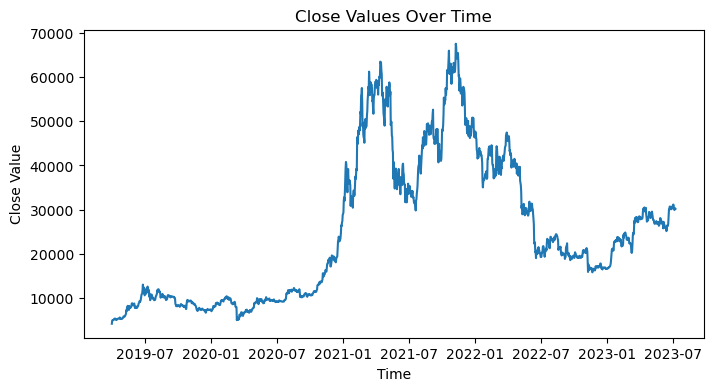

In [6]:
# Create the plot
plt.figure(figsize=(8, 4)) # you can adjust the size as needed
plt.plot(df_profolio["Close"])

# Add title and labels if needed
plt.title("Close Values Over Time")
plt.xlabel("Time")
plt.ylabel("Close Value")

# Save the plot
plt.savefig('./Images/stock.png')

----------------------------------------------

# 3. Data Processing

In [7]:
# Create a copy of the df_stock dataframe to calculate the actual_returns columns
df_stock_copy = df_stock.copy()

In [8]:
df_stock_copy["actual_returns"] = df_stock_copy["Close"].pct_change()
df_stock_copy.head()

Open         High          Low        Close  \
date                                                                            
2019-04-01 00:00:00+00:00  4105.362305  4164.953125  4096.901367  4158.183105   
2019-04-02 00:00:00+00:00  4156.919434  4905.954590  4155.316895  4879.877930   
2019-04-03 00:00:00+00:00  4879.958008  5307.003418  4876.621094  4973.021973   
2019-04-04 00:00:00+00:00  4971.307617  5063.159668  4836.793945  4922.798828   
2019-04-05 00:00:00+00:00  4922.806152  5053.509766  4919.491699  5036.681152   

                                Volume  Dividends  Stock Splits  \
date                                                              
2019-04-01 00:00:00+00:00  10157794171        0.0           0.0   
2019-04-02 00:00:00+00:00  21315047816        0.0           0.0   
2019-04-03 00:00:00+00:00  22899891582        0.0           0.0   
2019-04-04 00:00:00+00:00  18251810240        0.0           0.0   
2019-04-05 00:00:00+00:00  16837325387        0.0           0.0   

                           actual_returns  
date                                       
2019-04-01 00:00:00+00:00             NaN  
2019-04-02 00:00:00+00:00        0.173560  
2019-04-03 00:00:00+00:00        0.019087  
2019-04-04 00:00:00+00:00       -0.010099  
2019-04-05 00:00:00+00:00        0.023134

In [9]:
# Clean and review the dataframe
df_ml = df_stock_copy.dropna()
display(df_ml.head())
display(df_ml.tail())

Open         High          Low        Close  \
date                                                                            
2019-04-02 00:00:00+00:00  4156.919434  4905.954590  4155.316895  4879.877930   
2019-04-03 00:00:00+00:00  4879.958008  5307.003418  4876.621094  4973.021973   
2019-04-04 00:00:00+00:00  4971.307617  5063.159668  4836.793945  4922.798828   
2019-04-05 00:00:00+00:00  4922.806152  5053.509766  4919.491699  5036.681152   
2019-04-06 00:00:00+00:00  5036.792969  5205.821777  4992.222168  5059.817383   

                                Volume  Dividends  Stock Splits  \
date                                                              
2019-04-02 00:00:00+00:00  21315047816        0.0           0.0   
2019-04-03 00:00:00+00:00  22899891582        0.0           0.0   
2019-04-04 00:00:00+00:00  18251810240        0.0           0.0   
2019-04-05 00:00:00+00:00  16837325387        0.0           0.0   
2019-04-06 00:00:00+00:00  16929795194        0.0           0.0   

                           actual_returns  
date                                       
2019-04-02 00:00:00+00:00        0.173560  
2019-04-03 00:00:00+00:00        0.019087  
2019-04-04 00:00:00+00:00       -0.010099  
2019-04-05 00:00:00+00:00        0.023134  
2019-04-06 00:00:00+00:00        0.004594

Open          High           Low  \
date                                                                  
2023-07-05 00:00:00+00:00  30778.724609  30877.330078  30225.613281   
2023-07-06 00:00:00+00:00  30507.150391  31460.052734  29892.226562   
2023-07-07 00:00:00+00:00  29907.998047  30434.644531  29777.285156   
2023-07-08 00:00:00+00:00  30346.921875  30374.437500  30080.160156   
2023-07-09 00:00:00+00:00  30291.611328  30427.589844  30085.591797   

                                  Close       Volume  Dividends  Stock Splits  \
date                                                                            
2023-07-05 00:00:00+00:00  30514.166016  12481622280        0.0           0.0   
2023-07-06 00:00:00+00:00  29909.337891  21129219509        0.0           0.0   
2023-07-07 00:00:00+00:00  30342.265625  13384770155        0.0           0.0   
2023-07-08 00:00:00+00:00  30292.541016   7509378699        0.0           0.0   
2023-07-09 00:00:00+00:00  30171.234375   7903327692        0.0           0.0   

                           actual_returns  
date                                       
2023-07-05 00:00:00+00:00       -0.008559  
2023-07-06 00:00:00+00:00       -0.019821  
2023-07-07 00:00:00+00:00        0.014475  
2023-07-08 00:00:00+00:00       -0.001639  
2023-07-09 00:00:00+00:00       -0.004005

In [10]:
# Create simple moving averages and establish short and long windows
# Define a window size of 4
short_window = 4

# Create an SMA that uses short_window, and assign it to a new column named “sma_fast”
df_ml["sma_fast"] = df_ml["Close"].rolling(window=short_window).mean()

# Define a window size of 20
long_window = 20

# Create an SMA that uses long_window, and assign it to a new columns named “sma_slow”
df_ml["sma_slow"] = df_ml["Close"].rolling(window=long_window).mean()

trading_df = df_ml.dropna()

X = trading_df[["sma_fast", "sma_slow"]].shift().dropna().copy()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1488\4281308298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml["sma_fast"] = df_ml["Close"].rolling(window=short_window).mean()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1488\4281308298.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml["sma_slow"] = df_ml["Close"].rolling(window=long_window).mean()


In [11]:
X.head()

sma_fast     sma_slow
date                                               
2019-04-22 00:00:00+00:00  5313.653931  5155.896631
2019-04-23 00:00:00+00:00  5338.898804  5181.870996
2019-04-24 00:00:00+00:00  5406.036255  5211.838013
2019-04-25 00:00:00+00:00  5437.781372  5238.941406
2019-04-26 00:00:00+00:00  5411.777466  5247.633130

In [12]:
# Establish the logic for caclulating the signal column based on actual_returns value
trading_df["signal"] = 0.0
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1
y = trading_df["signal"].copy()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1488\1325196522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_df["signal"] = 0.0


In [13]:
# Establish begin and end timeframes
begin = X.index.min()
end = X.index.min() + DateOffset(months=24)

In [14]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[begin:end]
y_train = y.loc[begin:end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[end:]
y_test = y.loc[end:]

In [15]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [16]:
# Prepare dataframes for machine learning models later
X_df = df_ml[['Open','High','Low','Close','Volume','actual_returns']].reset_index().drop(columns=['date'])
X_nn = X_df[['Open','High','Low','Close','Volume']]

# Create a new column in the `trading_df` called "signal" setting its value to zero.
X_df["signal"] = 0.0

# Create the signal to buy
X_df.loc[(X_df["actual_returns"] >= 0), "signal"] = 1

# Create the signal to sell
X_df.loc[(X_df["actual_returns"] < 0), "signal"] = 0

-----------------------

# 4. Machine Learning Analysis

### Scikit-learn: Logistic Regression

In [17]:
# Establish the dataframe columns and perform train_test_split
X_lr = X_nn[['Open','High','Low','Close','Volume']]
y_lr = X_df['signal']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, random_state=42)

In [18]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model

logistic_regression_model = LogisticRegression(random_state=1)
lr_model = logistic_regression_model.fit(X_train_lr, y_train_lr)

In [19]:
# Make a prediction using the testing data
lr_predictions = lr_model.predict(X_train_lr)
testing_predictions = logistic_regression_model.predict(X_test_lr)

In [20]:
# Display the accuracy score for the test dataset.
accuracy_score(y_train_lr, lr_predictions)

0.5085470085470085

In [21]:
# Gen# Create and save the confustion matrix for the training data
training_matrix = confusion_matrix(y_train_lr, lr_predictions)
training_matrix

array([[  0, 575],
       [  0, 595]], dtype=int64)

In [22]:
# Create and save the confustion matrix for the testing data
test_matrix = confusion_matrix(y_test_lr, testing_predictions)
test_matrix

array([[  0, 187],
       [  0, 203]], dtype=int64)

In [23]:
 # Create and save the training classifiction report
report_lr = classification_report(y_train_lr, lr_predictions)

C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
testing_report_lr = classification_report(y_test_lr, testing_predictions)
print(testing_report_lr)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       187
         1.0       0.52      1.00      0.68       203

    accuracy                           0.52       390
   macro avg       0.26      0.50      0.34       390
weighted avg       0.27      0.52      0.36       390



C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------------

### Scikit-learn: Linear Regression

In [25]:
# Create the X set by using the `reshape` function to format the ads data as a single column array.
X_linear = df_ml[["Open", "High", "Low", "Close", "Volume"]].values

In [26]:
# Create an array for the dependent variable y with the sales data
y_linear = df_ml["actual_returns"]

In [27]:
# Create a model with scikit-learn
model_linear = LinearRegression()
# Fit the data into the model
model_linear.fit(X_linear, y_linear)

LinearRegression()

In [28]:
 # Display the slope
print(f"Model's slope: {model_linear.coef_}")

Model's slope: [-2.84579890e-05  2.14570457e-06 -1.16615960e-06  2.73394056e-05
  2.33146445e-14]


In [29]:
 # Display the y-intercept
print(f"Model's y-intercept: {model_linear.intercept_}")

Model's y-intercept: 0.0022653456232140396


In [30]:
 # Display the model's best fit line formula
print(f"Model's formula: y = {model_linear.intercept_} + {model_linear.coef_[0]}X")

Model's formula: y = 0.0022653456232140396 + -2.8457989006685473e-05X


In [31]:
 # Make predictions using the X set
predicted_linear = model_linear.predict(X_linear)

In [32]:
 # Create a copy of the original data
df_linear = df_ml.copy()

# Add a column with the predicted sales values
df_linear["returns_predicted"] = predicted_linear

# Display sample data
df_linear.head()

Open         High          Low        Close  \
date                                                                            
2019-04-02 00:00:00+00:00  4156.919434  4905.954590  4155.316895  4879.877930   
2019-04-03 00:00:00+00:00  4879.958008  5307.003418  4876.621094  4973.021973   
2019-04-04 00:00:00+00:00  4971.307617  5063.159668  4836.793945  4922.798828   
2019-04-05 00:00:00+00:00  4922.806152  5053.509766  4919.491699  5036.681152   
2019-04-06 00:00:00+00:00  5036.792969  5205.821777  4992.222168  5059.817383   

                                Volume  Dividends  Stock Splits  \
date                                                              
2019-04-02 00:00:00+00:00  21315047816        0.0           0.0   
2019-04-03 00:00:00+00:00  22899891582        0.0           0.0   
2019-04-04 00:00:00+00:00  18251810240        0.0           0.0   
2019-04-05 00:00:00+00:00  16837325387        0.0           0.0   
2019-04-06 00:00:00+00:00  16929795194        0.0           0.0   

                           actual_returns     sma_fast  sma_slow  \
date                                                               
2019-04-02 00:00:00+00:00        0.173560          NaN       NaN   
2019-04-03 00:00:00+00:00        0.019087          NaN       NaN   
2019-04-04 00:00:00+00:00       -0.010099          NaN       NaN   
2019-04-05 00:00:00+00:00        0.023134  4953.094971       NaN   
2019-04-06 00:00:00+00:00        0.004594  4998.079834       NaN   

                           returns_predicted  
date                                          
2019-04-02 00:00:00+00:00           0.023559  
2019-04-03 00:00:00+00:00           0.005585  
2019-04-04 00:00:00+00:00           0.001027  
2019-04-05 00:00:00+00:00           0.005371  
2019-04-06 00:00:00+00:00           0.003004

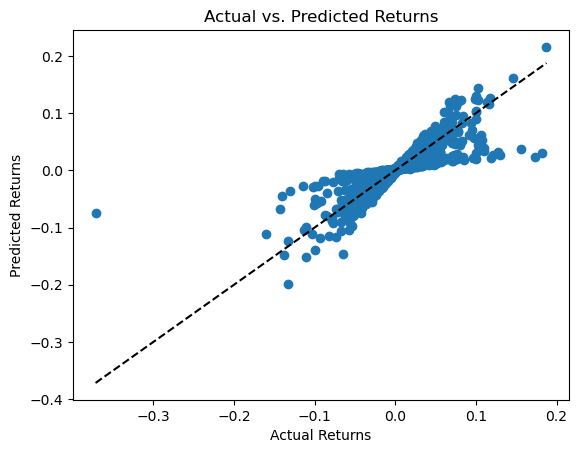

In [33]:
# Create a scatter plot of predicted vs. actual values
plt.scatter(y_linear, predicted_linear)
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Actual vs. Predicted Returns")

# Add a diagonal line, to indicate where the points would lie if the predictions were perfect
plt.plot([y_linear.min(), y_linear.max()], [y_linear.min(), y_linear.max()], 'k--')

plt.savefig('./Images/linear_plot')

In [34]:
# Compute the metrics for the linear regression model
score = model_linear.score(X_linear, y_linear, sample_weight=None)
r2 = r2_score(y_linear, predicted_linear)
mse = mean_squared_error(y_linear, predicted_linear)
rmse = np.sqrt(mse)
std = np.std(y_linear)

---------------

### GARCH
*Additional ML model not covered in class*

In [35]:
# Create the returns dataframe based on the actual_returns of the df_ml dataframe
returns = df_ml['actual_returns']

In [36]:
# Set up the GARCH model
model_garch = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

In [37]:
# Fit the GARCH Model
res = model_garch.fit(disp="off")
# Summarize the model results
res.summary()

C:\Anaconda\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:         actual_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2998.23
Distribution:                  Normal   AIC:                          -5990.46
Method:            Maximum Likelihood   BIC:                          -5974.40
                                        No. Observations:                 1560
Date:                Wed, Jul 12 2023   Df Residuals:                     1560
Time:                        20:56:01   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0337e-04  2.936e-05      3.521  4.296e-04 [4.583e-05,1.609e-04]
alpha[1]       0.1018  3.871e-02      2.630  8.532e-03   [2.594e-02,  0.178]
beta[1]        0.8279  3.593e-02     23.041 1.805e-117     [  0.757,  0.898]
============================================================================

Covariance estimator: robust
"""

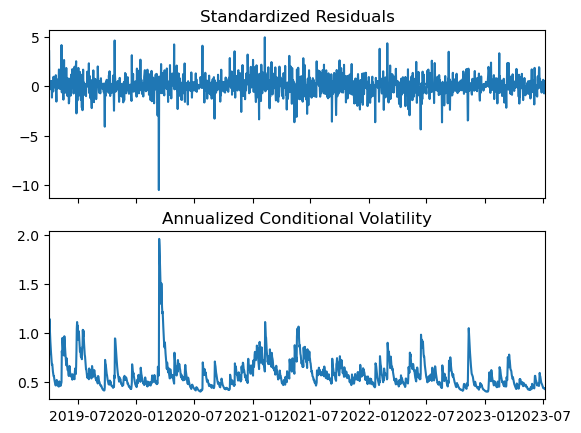

In [38]:
# Plot the model estimate of annualized volatility
fig_garch = res.plot(annualize='D')
# Save the plot
plt.savefig('./Images/garch.png')

In [39]:
# Forecasting from GARCH
# Construct Volatility Forecasts for the next 7 days
forecast_horizon = 7
# Take the last day of the data we used above. 
# If forecast horizon is 3, then the resulting 'h.1', 'h.2', and 'h.3' 
# are the forecasts for the following 7 days.
forecasts = res.forecast(start='2023-07-09', horizon=forecast_horizon)
forecasts

C:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [40]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate

h.1       h.2       h.3       h.4       h.5  \
date                                                                          
2023-07-09 00:00:00+00:00  0.419563  0.435552  0.449906  0.462853  0.474572   

                                h.6       h.7  
date                                           
2023-07-09 00:00:00+00:00  0.485213  0.494902

In [41]:
final = intermediate.dropna().T
final

date  2023-07-09 00:00:00+00:00
h.1                    0.419563
h.2                    0.435552
h.3                    0.449906
h.4                    0.462853
h.5                    0.474572
h.6                    0.485213
h.7                    0.494902

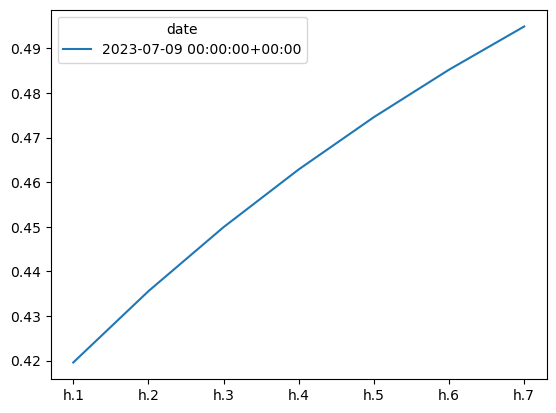

In [42]:
final_garch = final.plot()
plt.savefig('./Images/final_garch_plot.png')

-----------------------------------------------------------------------------------------------------

### Scikit-learn: Support Vector Machines (SVM)

In [43]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["Close"].pct_change()

# Display sample data
trading_df.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1488\2188810348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_df["actual_returns"] = trading_df["Close"].pct_change()


Open         High          Low        Close  \
date                                                                            
2019-04-21 00:00:00+00:00  5335.878906  5359.924805  5257.339355  5314.531250   
2019-04-22 00:00:00+00:00  5312.494629  5422.687500  5280.276855  5399.365234   
2019-04-23 00:00:00+00:00  5399.365723  5633.802246  5389.408691  5572.362305   
2019-04-24 00:00:00+00:00  5571.508301  5642.044434  5418.263184  5464.866699   
2019-04-25 00:00:00+00:00  5466.524414  5542.238281  5181.338867  5210.515625   

                                Volume  Dividends  Stock Splits  \
date                                                              
2019-04-21 00:00:00+00:00  13731844223        0.0           0.0   
2019-04-22 00:00:00+00:00  14601631648        0.0           0.0   
2019-04-23 00:00:00+00:00  15867308108        0.0           0.0   
2019-04-24 00:00:00+00:00  17048033399        0.0           0.0   
2019-04-25 00:00:00+00:00  15330283408        0.0           0.0   

                           actual_returns     sma_fast     sma_slow  signal  
date                                                                         
2019-04-21 00:00:00+00:00             NaN  5313.653931  5155.896631    -1.0  
2019-04-22 00:00:00+00:00        0.015963  5338.898804  5181.870996     1.0  
2019-04-23 00:00:00+00:00        0.032040  5406.036255  5211.838013     1.0  
2019-04-24 00:00:00+00:00       -0.019291  5437.781372  5238.941406    -1.0  
2019-04-25 00:00:00+00:00       -0.046543  5411.777466  5247.633130    -1.0

In [44]:
# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

Open         High          Low        Close  \
date                                                                            
2019-04-22 00:00:00+00:00  5312.494629  5422.687500  5280.276855  5399.365234   
2019-04-23 00:00:00+00:00  5399.365723  5633.802246  5389.408691  5572.362305   
2019-04-24 00:00:00+00:00  5571.508301  5642.044434  5418.263184  5464.866699   
2019-04-25 00:00:00+00:00  5466.524414  5542.238281  5181.338867  5210.515625   
2019-04-26 00:00:00+00:00  5210.304688  5383.634277  5177.368652  5279.348145   

                                Volume  Dividends  Stock Splits  \
date                                                              
2019-04-22 00:00:00+00:00  14601631648        0.0           0.0   
2019-04-23 00:00:00+00:00  15867308108        0.0           0.0   
2019-04-24 00:00:00+00:00  17048033399        0.0           0.0   
2019-04-25 00:00:00+00:00  15330283408        0.0           0.0   
2019-04-26 00:00:00+00:00  16812108040        0.0           0.0   

                           actual_returns     sma_fast     sma_slow  signal  
date                                                                         
2019-04-22 00:00:00+00:00        0.015963  5338.898804  5181.870996     1.0  
2019-04-23 00:00:00+00:00        0.032040  5406.036255  5211.838013     1.0  
2019-04-24 00:00:00+00:00       -0.019291  5437.781372  5238.941406    -1.0  
2019-04-25 00:00:00+00:00       -0.046543  5411.777466  5247.633130    -1.0  
2019-04-26 00:00:00+00:00        0.013210  5381.773193  5258.609668     1.0

Open          High           Low  \
date                                                                  
2023-07-05 00:00:00+00:00  30778.724609  30877.330078  30225.613281   
2023-07-06 00:00:00+00:00  30507.150391  31460.052734  29892.226562   
2023-07-07 00:00:00+00:00  29907.998047  30434.644531  29777.285156   
2023-07-08 00:00:00+00:00  30346.921875  30374.437500  30080.160156   
2023-07-09 00:00:00+00:00  30291.611328  30427.589844  30085.591797   

                                  Close       Volume  Dividends  Stock Splits  \
date                                                                            
2023-07-05 00:00:00+00:00  30514.166016  12481622280        0.0           0.0   
2023-07-06 00:00:00+00:00  29909.337891  21129219509        0.0           0.0   
2023-07-07 00:00:00+00:00  30342.265625  13384770155        0.0           0.0   
2023-07-08 00:00:00+00:00  30292.541016   7509378699        0.0           0.0   
2023-07-09 00:00:00+00:00  30171.234375   7903327692        0.0           0.0   

                           actual_returns      sma_fast      sma_slow  signal  
date                                                                           
2023-07-05 00:00:00+00:00       -0.008559  30767.239258  29582.202637    -1.0  
2023-07-06 00:00:00+00:00       -0.019821  30589.381348  29761.296387    -1.0  
2023-07-07 00:00:00+00:00        0.014475  30385.837891  29952.875879     1.0  
2023-07-08 00:00:00+00:00       -0.001639  30264.577637  30150.692285    -1.0  
2023-07-09 00:00:00+00:00       -0.004005  30178.844727  30316.702539    -1.0

#### Generating the Features and Target Sets

##### Creating the Features Set

In [45]:
# Define a window size of 4
short_window = 4

# Create an SMA that uses short_window, and assign it to a new column named “sma_fast”
trading_df["sma_fast"] = trading_df["Close"].rolling(window=short_window).mean()

In [46]:
# Define a window size of 20
long_window = 20

# Create an SMA that uses long_window, and assign it to a new columns named “sma_slow”
trading_df["sma_slow"] = trading_df["Close"].rolling(window=long_window).mean()

In [47]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

In [48]:
# Assign a copy of the `sma_fast` and `sma_slow` columns to a new DataFrame called `X`
X = trading_df[["sma_fast", "sma_slow"]].shift().dropna().copy()

# Display sample data
display(X.head())
display(X.tail())

sma_fast     sma_slow
date                                               
2019-05-12 00:00:00+00:00  6435.151733  5684.901465
2019-05-13 00:00:00+00:00  6682.630249  5763.551782
2019-05-14 00:00:00+00:00  7092.726807  5875.679419
2019-05-15 00:00:00+00:00  7496.618530  6002.156885
2019-05-16 00:00:00+00:00  7746.717651  6151.889502

sma_fast      sma_slow
date                                                 
2023-07-05 00:00:00+00:00  30786.217285  29335.314063
2023-07-06 00:00:00+00:00  30767.239258  29582.202637
2023-07-07 00:00:00+00:00  30589.381348  29761.296387
2023-07-08 00:00:00+00:00  30385.837891  29952.875879
2023-07-09 00:00:00+00:00  30264.577637  30150.692285

##### Creating the Target Set

In [49]:
# Create a new column in the `trading_df` called "signal" setting its value to zero.
trading_df["signal"] = 0.0

# Create the signal to buy
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1

# Create the signal to sell
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1

# Copy the new "signal" column to a new Series called `y`.
y = trading_df["signal"].copy()

#### Split the Data into Training and Testing Sets

In [50]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2019-05-12 00:00:00+00:00


In [51]:
# Select the ending period for the training data with an offset of 18 months
training_end = X.index.min() + DateOffset(months=24)

# Display the training end date
print(training_end)

2021-05-12 00:00:00+00:00


In [52]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [53]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

#### Standardize the Data

In [54]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

##### Using Machine Learning Into a Trading Strategy

In [55]:
# Create the classifier model
svm_model = svm.SVC()

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [56]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)

# Display report
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.54      0.09      0.16       347
         1.0       0.53      0.93      0.68       385

    accuracy                           0.53       732
   macro avg       0.54      0.51      0.42       732
weighted avg       0.54      0.53      0.43       732



##### Backtesting a Machine Learning Trading Algorithm

In [57]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [58]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)

# Display the report
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.50      0.07      0.12       405
         1.0       0.49      0.93      0.64       384

    accuracy                           0.49       789
   macro avg       0.49      0.50      0.38       789
weighted avg       0.49      0.49      0.37       789



##### Visually Compare the Actual and Predicted Returns

In [59]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = trading_df["actual_returns"]

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
predictions_df.head()

predicted_signal  actual_returns  \
date                                                          
2021-05-12 00:00:00+00:00              -1.0       -0.133217   
2021-05-13 00:00:00+00:00              -1.0        0.011509   
2021-05-14 00:00:00+00:00              -1.0        0.003306   
2021-05-15 00:00:00+00:00               1.0       -0.062556   
2021-05-16 00:00:00+00:00               1.0       -0.006504   

                           trading_algorithm_returns  
date                                                  
2021-05-12 00:00:00+00:00                   0.133217  
2021-05-13 00:00:00+00:00                  -0.011509  
2021-05-14 00:00:00+00:00                  -0.003306  
2021-05-15 00:00:00+00:00                  -0.062556  
2021-05-16 00:00:00+00:00                  -0.006504

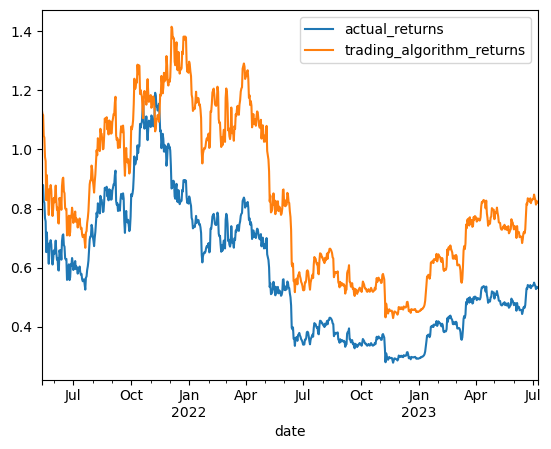

In [60]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()
plt.savefig("./Images/svm.png") 

------------------

## Neural Networks - Tensorflow, Keras

In [61]:
# Create a new column in the `trading_df` called "signal" setting its value to zero.
X_df["signal"] = 0.0

# Create the signal to buy
X_df.loc[(X_df["actual_returns"] >= 0), "signal"] = 1

# Create the signal to sell
X_df.loc[(X_df["actual_returns"] < 0), "signal"] = 0

y_nn = X_df["signal"].copy()

In [62]:
# Apply Train-test-split to get tarin and test data
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, random_state=1)

In [63]:
 # Create the StandardScaler instance
X_scaler_nn = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler_nn.fit(X_train_nn)

# Scale both the training and testing data from the features dataset
X_train_scaled_nn = X_scaler_nn.transform(X_train_nn)
X_test_scaled_nn = X_scaler_nn.transform(X_test_nn)

In [64]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_nn.columns)

In [65]:
# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 =  12

# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = 6

# Create the Sequential model instance
nn = Sequential()


In [66]:
# Add the first hidden layer specifying the number of inputs, the number of hidden nodes, and the activation function
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Add the second hidden layer specifying the number of hidden nodes and the activation function
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units=1, activation="sigmoid"))

In [67]:
# Display the Sequential model summary
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                72        
                                                                 
 dense_1 (Dense)             (None, 6)                 78        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Compile the Sequential model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [69]:
# Fit the model using 50 epochs and the training data
num_epochs = 100
model_1 = nn.fit(X_train_scaled_nn, y_train_nn, epochs=num_epochs)

Epoch 1/100
37/37 [==============================] - 1s 2ms/step - loss: 0.7147 - accuracy: 0.4889
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6971 - accuracy: 0.5034
Epoch 3/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.5145
Epoch 4/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.5222
Epoch 5/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6920 - accuracy: 0.5350
Epoch 6/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6919 - accuracy: 0.5308
Epoch 7/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6910 - accuracy: 0.5299
Epoch 8/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6908 - accuracy: 0.5350
Epoch 9/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6906 - accuracy: 0.5222
Epoch 10/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6907 - accuracy: 0.5274
Epoch 11/

In [70]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled_nn, y_test_nn)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

13/13 [==============================] - 0s 1ms/step - loss: 0.5500 - accuracy: 0.7795
Loss: 0.5500078797340393, Accuracy: 0.7794871926307678


In [71]:
# Set the model's file path
file_path = Path('Resources/nn.h5')

# Export your model to a HDF5 file
nn.save(file_path)

----------

## Prophet

In [72]:
# Reset index and rename columns for Prophet model ingestion
df = df_profolio.reset_index()
df.columns = ["ds", "y"]
display(df.shape)
display(df.head())
display(df.tail())

(1561, 2)

ds            y
0 2019-04-01 00:00:00+00:00  4158.183105
1 2019-04-02 00:00:00+00:00  4879.877930
2 2019-04-03 00:00:00+00:00  4973.021973
3 2019-04-04 00:00:00+00:00  4922.798828
4 2019-04-05 00:00:00+00:00  5036.681152

ds             y
1556 2023-07-05 00:00:00+00:00  30514.166016
1557 2023-07-06 00:00:00+00:00  29909.337891
1558 2023-07-07 00:00:00+00:00  30342.265625
1559 2023-07-08 00:00:00+00:00  30292.541016
1560 2023-07-09 00:00:00+00:00  30171.234375

In [73]:
# Establish localisation for the ds column timezone
df['ds'] = df['ds'].dt.tz_localize(None)

In [74]:
# Sort the ds columns
df = df.sort_values(by=["ds"], ascending=True)

# Display sample data from head and tail
display(df.head(10))
display(df.tail(10))

ds            y
0 2019-04-01  4158.183105
1 2019-04-02  4879.877930
2 2019-04-03  4973.021973
3 2019-04-04  4922.798828
4 2019-04-05  5036.681152
5 2019-04-06  5059.817383
6 2019-04-07  5198.896973
7 2019-04-08  5289.770996
8 2019-04-09  5204.958496
9 2019-04-10  5324.551758

ds             y
1551 2023-06-30  30477.251953
1552 2023-07-01  30590.078125
1553 2023-07-02  30620.769531
1554 2023-07-03  31156.439453
1555 2023-07-04  30777.582031
1556 2023-07-05  30514.166016
1557 2023-07-06  29909.337891
1558 2023-07-07  30342.265625
1559 2023-07-08  30292.541016
1560 2023-07-09  30171.234375

In [75]:
# Call the Prophet function, store as an object
pr_model = Prophet()

# Fit the Prophet model.
pr_model.fit(df)

20:56:10 - cmdstanpy - INFO - Chain [1] start processing
20:56:10 - cmdstanpy - INFO - Chain [1] done processing


In [76]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 1000 hours (approx 40 days)
pr_future_trends = pr_model.make_future_dataframe(periods=1000, freq="H")

In [77]:
# View the last five rows of the predictions
pr_future_trends.tail()

ds
2556 2023-08-19 12:00:00
2557 2023-08-19 13:00:00
2558 2023-08-19 14:00:00
2559 2023-08-19 15:00:00
2560 2023-08-19 16:00:00

In [78]:
# Make the predictions for the trend data using the future_trends DataFrame
pr_forecast_trends1 = pr_model.predict(pr_future_trends)

# Display the first five rows of the forecast DataFrame
pr_forecast_trends1.head()

ds        trend   yhat_lower    yhat_upper  trend_lower  \
0 2019-04-01  2259.117168  3159.465192  10787.309918  2259.117168   
1 2019-04-02  2341.456011  2931.784830  10782.758712  2341.456011   
2 2019-04-03  2423.794853  3099.904451  11268.838067  2423.794853   
3 2019-04-04  2506.133696  3233.776621  10987.307611  2506.133696   
4 2019-04-05  2588.472538  3006.139951  11227.771976  2588.472538   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  2259.117168     4632.609228           4632.609228           4632.609228   
1  2341.456011     4630.669489           4630.669489           4630.669489   
2  2423.794853     4678.744981           4678.744981           4678.744981   
3  2506.133696     4546.460976           4546.460976           4546.460976   
4  2588.472538     4532.007245           4532.007245           4532.007245   

      weekly  weekly_lower  weekly_upper       yearly  yearly_lower  \
0  -0.810179     -0.810179     -0.810179  4633.419407   4633.419407   
1  -8.790724     -8.790724     -8.790724  4639.460213   4639.460213   
2  53.800009     53.800009     53.800009  4624.944972   4624.944972   
3 -45.732472    -45.732472    -45.732472  4592.193448   4592.193448   
4 -11.764464    -11.764464    -11.764464  4543.771709   4543.771709   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0   4633.419407                   0.0                         0.0   
1   4639.460213                   0.0                         0.0   
2   4624.944972                   0.0                         0.0   
3   4592.193448                   0.0                         0.0   
4   4543.771709                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  6891.726397  
1                         0.0  6972.125500  
2                         0.0  7102.539834  
3                         0.0  7052.594672  
4                         0.0  7120.479783

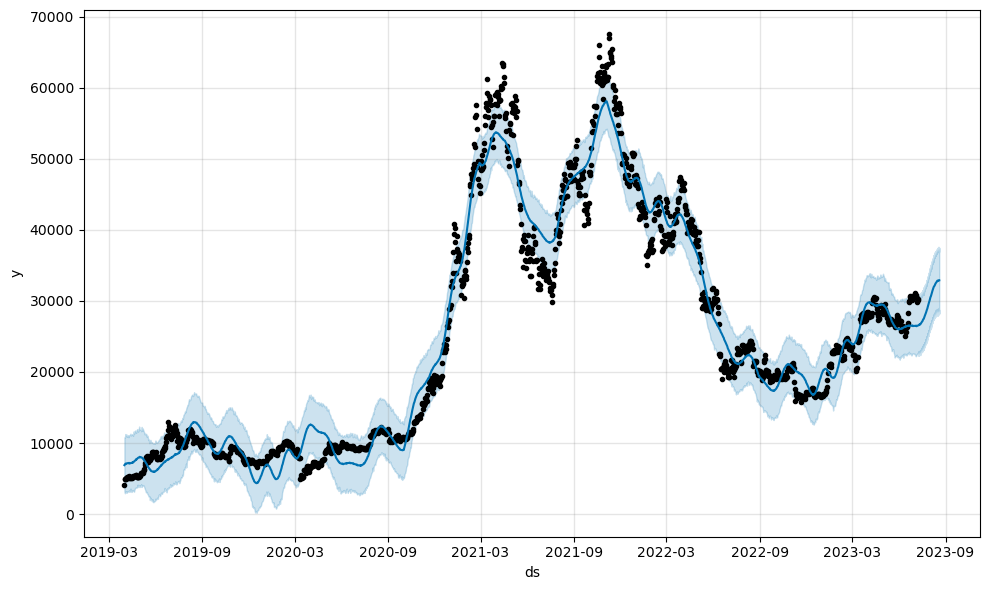

In [79]:
# Plot the Prophet predictions for the Mercado trends data
pr_fig = pr_model.plot(pr_forecast_trends1)
# Save the plot
plt.savefig('./Images/prophet.png')
# Display the plot
plt.show()

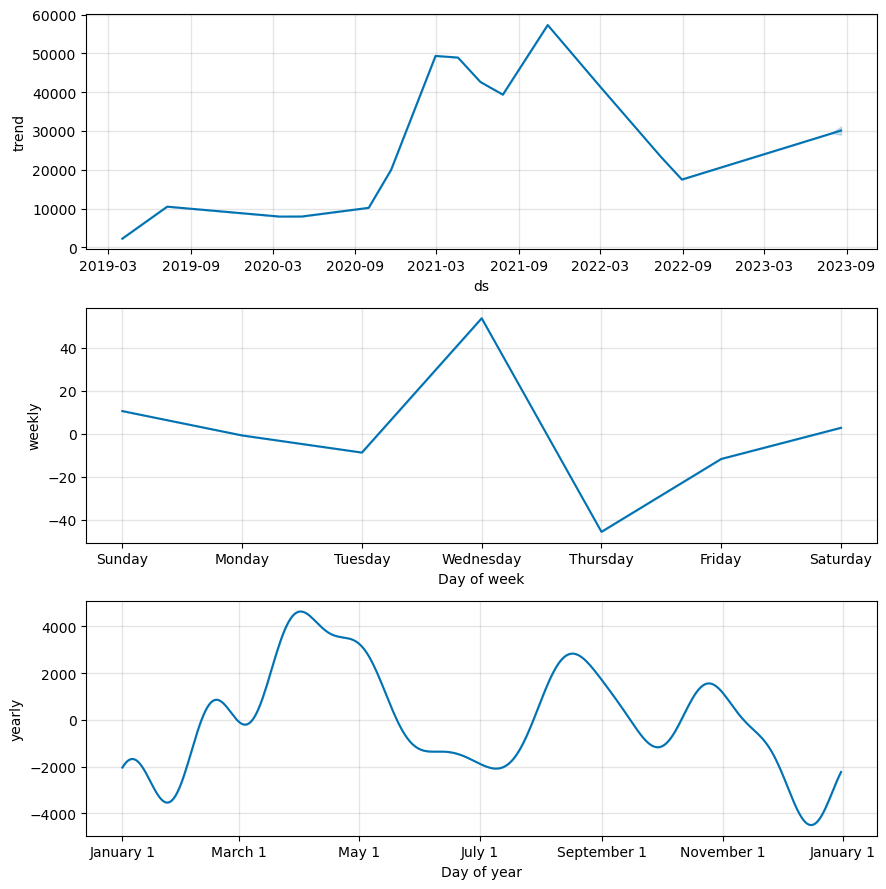

In [80]:
# Use the plot_components function to visualize the forecast results 
pr_figures = pr_model.plot_components(pr_forecast_trends1)
# Save the plot
plt.savefig('./Images/prophet_components.png')

In [81]:
# At this point, it's useful to set the `datetime` index of the forecast data.
pr_forecast_trends1 = pr_forecast_trends1.set_index(["ds"])

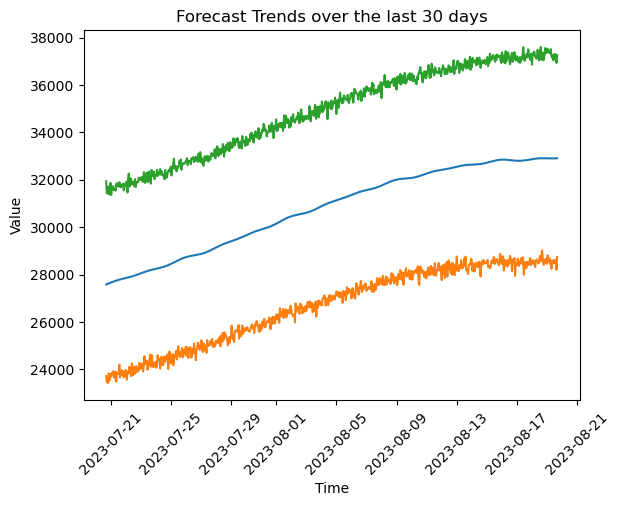

In [82]:
# Plot the yhat, yhat_lower, and yhat_upper columns over the last 30 days
pr_plot_last30days = plt.plot(pr_forecast_trends1[["yhat", "yhat_lower", "yhat_upper"]].iloc[-720:, :])
plt.title("Forecast Trends over the last 30 days")
plt.xlabel("Time")
plt.ylabel("Value")
plt.xticks(rotation=45)

# Save the plot
plt.savefig('./Images/prophet_predict.png')


In [83]:
# The DataFrame should include the columns yhat_upper, yhat_lower, and yhat
pr_forecast_aug_2023 = pr_forecast_trends1.loc["2023-07-13":"2023-08-13"][["yhat_upper", "yhat_lower", "yhat"]]

# Replace the column names to something less technical sounding
pr_forecast_aug_2023 = pr_forecast_aug_2023.rename(
    columns={
        "yhat_upper": "Best Case",
        "yhat_lower": "Worst Case", 
        "yhat": "Most Likely Case"
    }
)

# Review the last five rows of the DataFrame
pr_forecast_aug_2023.tail()

Best Case    Worst Case  Most Likely Case
ds                                                               
2023-08-13 19:00:00  36890.795288  28392.494726      32632.913811
2023-08-13 20:00:00  36917.032265  28436.294619      32634.783528
2023-08-13 21:00:00  37190.451738  28414.215219      32636.461015
2023-08-13 22:00:00  36634.726992  28507.145917      32637.973562
2023-08-13 23:00:00  36776.396979  28671.210170      32639.350903

In [84]:
# Display the average forecasted price for March 2021
pr_forecast_aug_2023.mean()

Best Case           33566.164431
Worst Case          25505.976442
Most Likely Case    29518.596289
dtype: float64

------------------

# 5. Model Reports:
*Summary of outputs and comparison*

## Logistic Regression

In [85]:
print(report_lr)
print(testing_report_lr)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       575
         1.0       0.51      1.00      0.67       595

    accuracy                           0.51      1170
   macro avg       0.25      0.50      0.34      1170
weighted avg       0.26      0.51      0.34      1170

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       187
         1.0       0.52      1.00      0.68       203

    accuracy                           0.52       390
   macro avg       0.26      0.50      0.34       390
weighted avg       0.27      0.52      0.36       390



## Linear Regression

In [86]:
# Print releveant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The score is 0.6877628577002539.
The r2 is 0.6877628577002539.
The mean squared error is 0.00042285915549689746.
The root mean squared error is 0.02056353946909183.
The standard deviation is 0.036800658282997535.


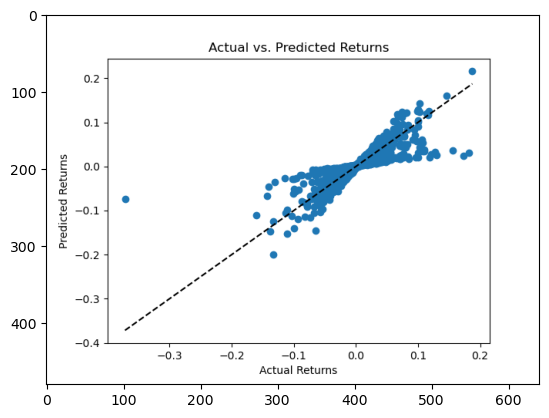

In [87]:
img_linear = mpimg.imread('./Images/linear_plot.png')
imgplot_linear = plt.imshow(img_linear)
plt.show()

## GARCH

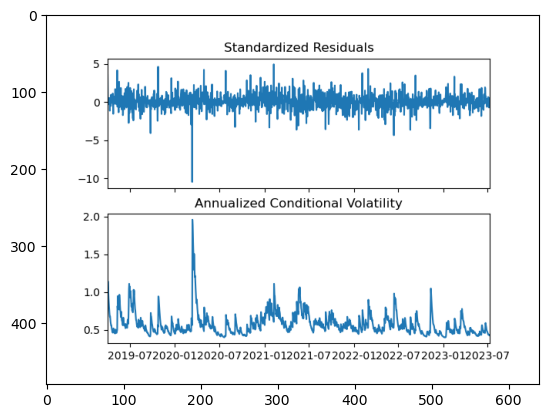

In [88]:
img_garch = mpimg.imread('./Images/garch.png')
imgplot_garch = plt.imshow(img_garch)
plt.show()

In [89]:
print(final)

date  2023-07-09 00:00:00+00:00
h.1                    0.419563
h.2                    0.435552
h.3                    0.449906
h.4                    0.462853
h.5                    0.474572
h.6                    0.485213
h.7                    0.494902


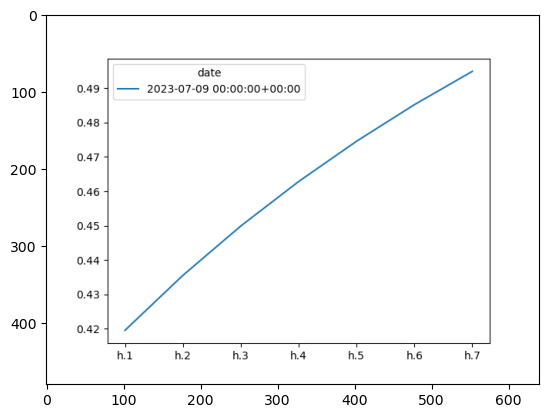

In [90]:
img_garch_final = mpimg.imread('./Images/final_garch_plot.png')
imgplot_garch_final = plt.imshow(img_garch_final)
plt.show()

## SVM

In [91]:
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.54      0.09      0.16       347
         1.0       0.53      0.93      0.68       385

    accuracy                           0.53       732
   macro avg       0.54      0.51      0.42       732
weighted avg       0.54      0.53      0.43       732



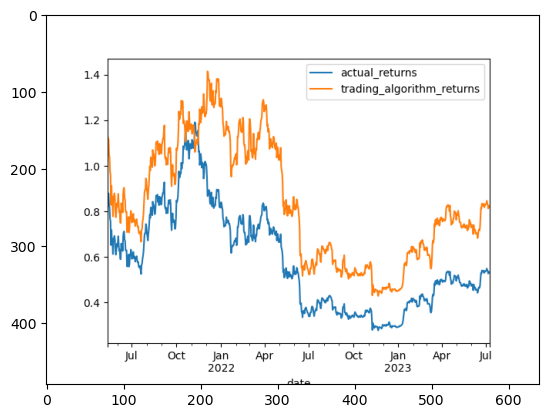

In [92]:
img_svm = mpimg.imread('./Images/svm.png')
imgplot_svm = plt.imshow(img_svm)
plt.show()

## Neural Network ML

In [93]:
# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Loss: 0.5500078797340393, Accuracy: 0.7794871926307678


## Prophet

In [94]:
print(pr_forecast_aug_2023.mean())

Best Case           33566.164431
Worst Case          25505.976442
Most Likely Case    29518.596289
dtype: float64


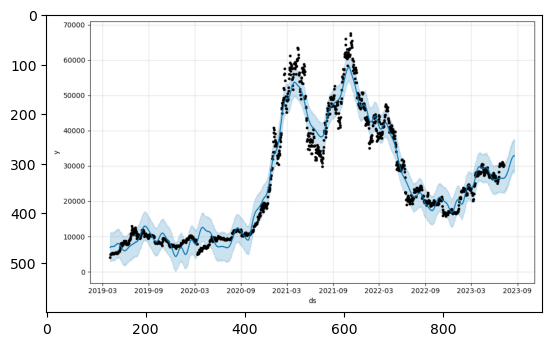

In [95]:
img_pr= mpimg.imread('./Images/prophet.png')
imgplot_pr = plt.imshow(img_pr)
plt.show()

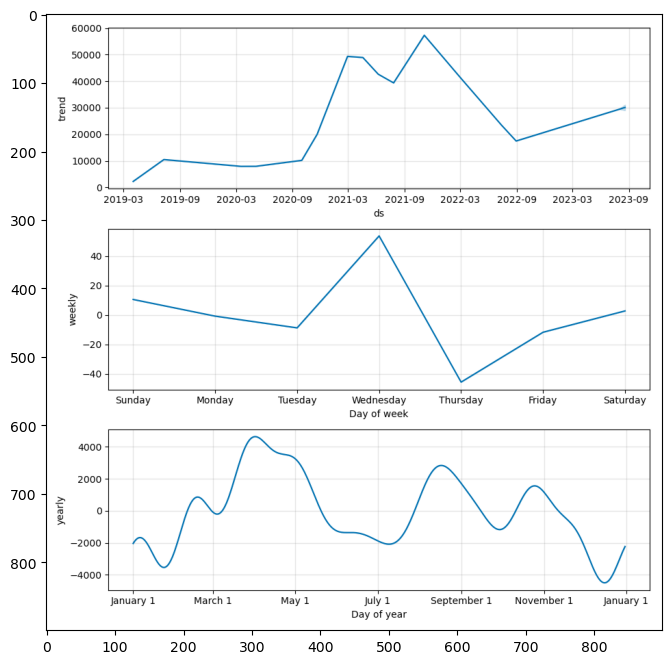

In [96]:
img_pr_com= mpimg.imread('./Images/prophet_components.png')
plt.figure(figsize=(8, 8))
imgplot_pr_com = plt.imshow(img_pr_com)
plt.show()

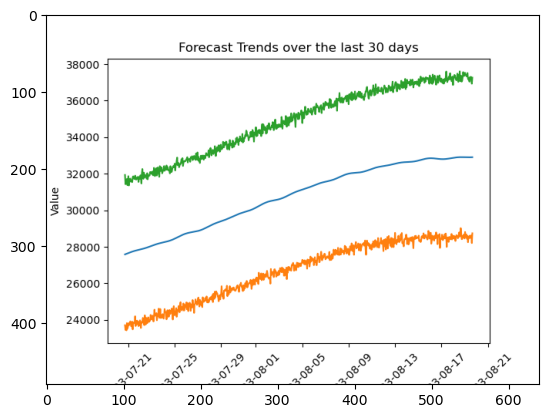

In [97]:
img_pr_predict= mpimg.imread('./Images/prophet_predict.png')
imgplot_pr_predict = plt.imshow(img_pr_predict)
plt.show()

------------

# 6. Deep Dive: Linear Regression Forecast vs Prophet Forecast

In [98]:
# Create a StandardScaler instance
data_Close = df_stock['Close'].to_numpy().reshape(-1,1)
scaler_Close = StandardScaler()

# Fit the scaler to the features training dataset
scaler_Close.fit(data_Close)
X_Close = scaler_Close.transform(data_Close)
print(scaler_Close.mean_)
print(scaler_Close.var_)
print(scaler_Close.n_samples_seen_)

[24930.80035334]
[2.6603135e+08]
1561


In [99]:
# Manually split data into training/testing data
test_ratio = 0.25
input_dim = 30 # 30 days of input data
output_dim = 1 # 1 day of output data

# Convert Vector to Array
X_Close = X_Close.reshape(-1,1)

N, p = X_Close.shape
input_dim = np.uint32(input_dim)
output_dim = np.uint32(output_dim)

if N<input_dim+output_dim or p !=1:
    print(f'check {input_dim}+{output_dim}>={N}?')
    print(f'check {p} == 1?')
    print('Error: Check Row input_dim+out <= Number and V should be column matrix')
M = np.zeros([N-input_dim-output_dim+1, input_dim+output_dim])
print(M.shape)
display(M)

(1531, 31)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [100]:
# Create the Matrix required for the split inot training/testing data
for i in range(N-input_dim-output_dim+1):
    M[i,:] = X_Close[i : input_dim+output_dim+i].flat # add the window to the output matrix 
    M
M_Close = M
print(M.shape)
display(M)

(1531, 31)


array([[-1.27357583, -1.22932849, -1.2236178 , ..., -1.20679851,
        -1.20046061, -1.19727427],
       [-1.22932849, -1.2236178 , -1.226697  , ..., -1.20046061,
        -1.19727427, -1.19098466],
       [-1.2236178 , -1.226697  , -1.21971484, ..., -1.19727427,
        -1.19098466, -1.17485969],
       ...,
       [ 0.08676623,  0.09671191,  0.09500492, ...,  0.34231794,
         0.30523574,  0.33177867],
       [ 0.09671191,  0.09500492,  0.05643246, ...,  0.30523574,
         0.33177867,  0.32873004],
       [ 0.09500492,  0.05643246,  0.06188465, ...,  0.33177867,
         0.32873004,  0.32129269]])

In [101]:
# Train & Test data based on Ratio Split
n_row, n_col = M_Close.shape

X = M_Close[:,0:n_col-1] 
y = M_Close[:,-1] # Only the last column we created 

train_ratio = 1-test_ratio
n_train = int(n_row*train_ratio) 

# Create Train Data
X_train = X[0:n_train][:]
y_train = y[0:n_train][:]    

# Create Test Data
X_test = X[n_train+1:][:] # this [:] must refer to all columns
y_test = y[n_train+1:][:]   

print("Training sample")
print(str(X_train.shape))
print("Testing sample")
print(str(X_test.shape)) 

Training sample
(1148, 30)
Testing sample
(382, 30)


## Execute Linear Regression

In [102]:
from sklearn import linear_model
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train,y_train)
y_pred_lr = lr_model.predict(X_test)
y_pred_lr.shape

(382,)

## Evaluate Model Performance

In [103]:
print(f'Loss Absolute Error: {np.mean(np.abs(np.array(scaler_Close.inverse_transform(y_test.reshape(-1,1))) - np.array(scaler_Close.inverse_transform(y_pred_lr.reshape(-1,1)))))}')
print(f'Loss Absolute Percentage Error: {np.mean(np.abs((np.array(scaler_Close.inverse_transform(y_test.reshape(-1,1))) - np.array(scaler_Close.inverse_transform(y_pred_lr.reshape(-1,1))))/np.array(scaler_Close.inverse_transform(y_test.reshape(-1,1))))*100)} %')

Loss Absolute Error: 426.4820602855856
Loss Absolute Percentage Error: 1.8991096664114595 %


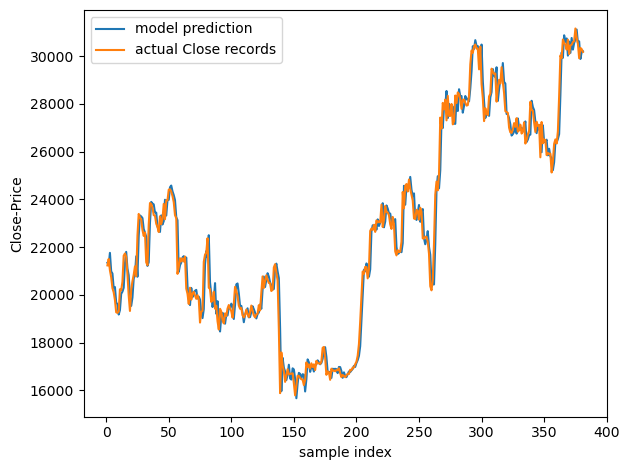

In [104]:
# PLot Prediction vs Actaul
t = np.arange(1,y_pred_lr.shape[0])
fig, ax = plt.subplots()
line1, = ax.plot(t, scaler_Close.inverse_transform(y_pred_lr.reshape(-1,1)[t]), label='model prediction')
line2, = ax.plot(t, scaler_Close.inverse_transform(y_test.reshape(-1,1)[t]), label='actual Close records')    
plt.xlabel('sample index')
plt.ylabel('Close-Price')
ax.legend()
fig.tight_layout()
plt.show()

In [105]:
lr_y_pred = scaler_Close.inverse_transform(y_pred_lr.reshape(-1,1))
df_y_pred = pd.DataFrame(lr_y_pred)
df_y_pred = df_y_pred.set_index(df_stock.index[-y_pred_lr.shape[0]:])
df_y_pred.columns = ['LR_pred']
df_y_pred

LR_pred
date                                   
2022-06-23 00:00:00+00:00  20094.812580
2022-06-24 00:00:00+00:00  21345.277046
2022-06-25 00:00:00+00:00  21237.806343
2022-06-26 00:00:00+00:00  21757.198452
2022-06-27 00:00:00+00:00  20981.068475
...                                 ...
2023-07-05 00:00:00+00:00  30558.282096
2023-07-06 00:00:00+00:00  30618.609085
2023-07-07 00:00:00+00:00  29879.785559
2023-07-08 00:00:00+00:00  30165.341499
2023-07-09 00:00:00+00:00  30203.252845

[382 rows x 1 columns]

In [106]:
df_lr_forecast =pd.concat([df_stock['Close'],df_y_pred['LR_pred']],axis=1)
df_lr_forecast.hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [107]:
# Create Prophet dataframe

df_prohpet = df_stock['Close']
df_prophet = df_prohpet.reset_index() # YOUR CODE HERE

# Label the columns ds and y so that the syntax is recognized by Prophet
# YOUR CODE HERE
df_prophet.columns = ['ds','y']

# Remove Timezone
df_prophet['ds']= df_prophet['ds'].dt.tz_localize(None)

# Drop an NaN values from the prophet_df DataFrame
df_prophet = df_prophet.dropna()# YOUR CODE HERE

# View the first and last five rows of the mercado_prophet_df DataFrame
# YOUR CODE HERE
display(df_prophet.head(5))
display(df_prophet.tail(5))

ds            y
0 2019-04-01  4158.183105
1 2019-04-02  4879.877930
2 2019-04-03  4973.021973
3 2019-04-04  4922.798828
4 2019-04-05  5036.681152

ds             y
1556 2023-07-05  30514.166016
1557 2023-07-06  29909.337891
1558 2023-07-07  30342.265625
1559 2023-07-08  30292.541016
1560 2023-07-09  30171.234375

In [108]:
# Call the Prophet function, store as an object
pr_model1 = Prophet()

forecast_periods = 60

# Fit the Prophet model.
pr_model1.fit(df_prophet)

# Create a future dataframe to hold predictions
# Make the prediction go out as far as 60 days
pr_future_trends = pr_model1.make_future_dataframe(periods=forecast_periods, freq="D")

# Make the predictions for the trend data using the future_trends DataFrame
df_prophet_forecast = pr_model1.predict(pr_future_trends) # YOUR CODE HERE

20:56:15 - cmdstanpy - INFO - Chain [1] start processing
20:56:16 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
prophet_plot = df_prophet_forecast[['yhat']].set_index(df_prophet_forecast['ds'])
prophet_plot.hvplot(label='Prophet') * df_stock['Close'].hvplot(label='Close')

:Overlay
   .Curve.Prophet :Curve   [ds]   (yhat)
   .Curve.Close   :Curve   [date]   (Close)

## Train the Linear Regression Using Prohet's Forecasted Data

In [110]:
# Scale and fit the new data input
df_prophet_forecast_yhat = df_prophet_forecast['yhat'].to_numpy().reshape(-1,1)
scaler_Close.fit(df_prophet_forecast_yhat)
prophet_yhat_scaled = scaler_Close.transform(df_prophet_forecast_yhat)

# Update train data
X_test_future = np.append(X_test,prophet_yhat_scaled[-forecast_periods:]) 

#Create new Matrix of the data
forecast_periods_int = np.uint32(forecast_periods)
forecast_periods_int_by2 = np.uint32(forecast_periods/2)

M_future = np.zeros([forecast_periods, forecast_periods_int_by2])
print(M_future.shape)
display(M_future)

(60, 30)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [111]:
# Fill the data for training/testing
for i in range(forecast_periods_int_by2):
    M_future[i,:] = X_test_future[i : forecast_periods_int_by2+i].flat 
    M_future
M_Close_future = M_future[:30]
print(M_Close_future.shape)

# Predict the the new forecast
y_pred_prophet_forecast = lr_model.predict(M_Close_future)

(30, 30)


In [112]:
# Evaluate the new Prediction
print(f'Loss Absolute Error: {np.mean(np.abs(np.array(scaler_Close.inverse_transform(M_Close_future[:,0].reshape(-1,1))) - np.array(scaler_Close.inverse_transform(y_pred_prophet_forecast.reshape(-1,1)))))}')
print(f'Loss Absolute Percentage Error: {np.mean(np.abs((np.array(scaler_Close.inverse_transform(M_Close_future[:,0].reshape(-1,1))) - np.array(scaler_Close.inverse_transform(y_pred_prophet_forecast.reshape(-1,1))))/np.array(scaler_Close.inverse_transform(M_Close_future[:,0].reshape(-1,1))))*100)} %')

Loss Absolute Error: 613.4748992130961
Loss Absolute Percentage Error: 2.2125204153558955 %


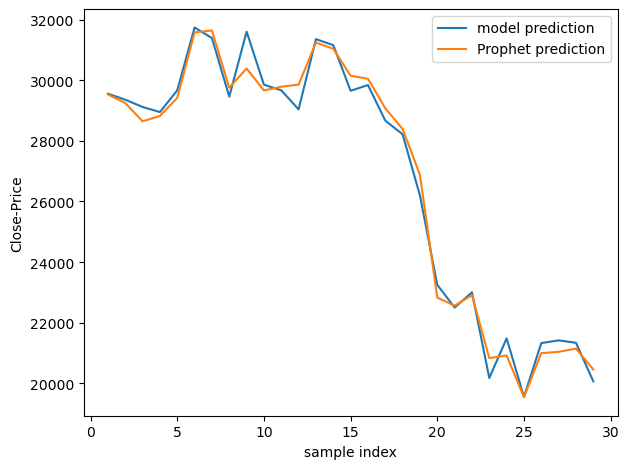

In [113]:
# Visualize the Evaluation
t = np.arange(1,y_pred_prophet_forecast.shape[0])
fig, ax = plt.subplots()
line1, = ax.plot(t, scaler_Close.inverse_transform(y_pred_prophet_forecast.reshape(-1,1)[t]), label='model prediction')
line2, = ax.plot(t, scaler_Close.inverse_transform(M_Close_future[:,0].reshape(-1,1)[t]), label='Prophet prediction')    
plt.xlabel('sample index')
plt.ylabel('Close-Price')
ax.legend()
fig.tight_layout()
plt.show()

In [114]:
# Create dataframe of new Preidction to concat with other data
prophet_y_future = scaler_Close.inverse_transform(y_pred_prophet_forecast[1:].reshape(-1,1))
df_prophet_y_future = pd.DataFrame(prophet_y_future)
df_prophet_forecast_ = df_prophet_forecast.rename(columns = {'ds':'date'})
df_prophet_y_future = df_prophet_y_future.set_index(df_prophet_forecast_['date'].iloc[-y_pred_prophet_forecast.shape[0]*2:-y_pred_prophet_forecast.shape[0]-1])
df_prophet_y_future.columns = ['y_pred_prophet_forecast']
df_prophet_y_future.head()

y_pred_prophet_forecast
date                               
2023-07-10             29554.737317
2023-07-11             29358.731039
2023-07-12             29117.666698
2023-07-13             28949.529389
2023-07-14             29667.589562

In [143]:
# Arrange data for concat
df_stock_tz = df_stock.reset_index()
df_stock_tz['date']= df_stock_tz['date'].dt.tz_localize(None)
df_stock_tz = df_stock_tz.set_index('date')

# Concat the new prediction with Prophet and Actual
df_lr_prophet_forecast_predict =pd.concat([df_stock_tz[['Close']],prophet_plot.iloc[:-30], df_prophet_y_future.iloc[:-5]],axis=1)

In [116]:
# Arrange data to concate new and old predictions
df_y_pred_tz = df_y_pred.reset_index()
df_y_pred_tz['date']= df_y_pred_tz['date'].dt.tz_localize(None)
df_y_pred_tz = df_y_pred_tz.set_index('date')
df_y_pred_tz = df_y_pred_tz.rename(columns = {'LR_pred':'y_pred_prophet_forecast'})

# Concate old and new predictions to previous data
df_prophet_y_future_old = pd.concat([df_y_pred_tz,df_prophet_y_future], axis=0, join ='inner')
df_prophet_y_future_old.tail()

y_pred_prophet_forecast
date                               
2023-08-03             19550.209143
2023-08-04             21325.237686
2023-08-05             21414.820684
2023-08-06             21334.652515
2023-08-07             20063.096502

In [117]:
# Visualize the new predictions vs Prophet and Actual
df_lr_prophet_forecast_predict_old = df_stock_tz[['Close']].hvplot(label='Actual', width=1000, height = 700, line_width=3) * prophet_plot.iloc[:-30].hvplot(label ='Prophet') * df_prophet_y_future_old.iloc[:-5].hvplot(label ='LR Predict', line_width=2, color ='black')
df_lr_prophet_forecast_predict_old

:Overlay
   .Curve.Actual     :Curve   [date]   (Close)
   .Curve.Prophet    :Curve   [ds]   (yhat)
   .Curve.LR_Predict :Curve   [date]   (y_pred_prophet_forecast)

In [119]:
# Ensure it renders using the 'bokeh' backend
hv.extension('bokeh')

# Save the plot
hv.save(df_lr_prophet_forecast_predict_old, './Images/df_lr_prophet_forecast_predict_old.png')

-------------

# 7. Additional Work

## Sentiment Analysis APIs

**Fear and Greed Index:**
Categories: extreme fear, fear, neutral, greed, extream greed*
* "< 50" : Fear
* "= 50" : Neutral
* "> 50" : Greed

In [120]:
# Set up the sentiment dataframe based on the fear_and_greed index
sentiment = pd.DataFrame(
    fear_and_greed.get(), 
    index=['value','description','last_update'], 
    columns=['CNN Fear & Greed Index']
)
sentiment

CNN Fear & Greed Index
value                        79.371429
description              extreme greed
last_update  2023-07-12 10:22:01+00:00

In [121]:
sentiment.loc['description']

CNN Fear & Greed Index    extreme greed
Name: description, dtype: object

In [122]:
sentiment.iloc[[0]]

CNN Fear & Greed Index
value              79.371429

-----------

## Connecting to external market to place orders

In [126]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url= 'https://paper-api.alpaca.markets',    
    api_version = "v2"
)

## Alpaca Buy/Sell Functions

In [128]:
# Define Alpaca buy function for crypto/stocks

def buy_crypto(token,amount):
    quantity_bought = 0
    position_price = 0
    amount_paid = 0    
    buy = api.submit_order(
  symbol=token, 
  side='buy',
  notional=float(amount),
  type='market',
  time_in_force='gtc'
)
    buy_id = buy.id          
    buy_order_status = buy.status
    time.sleep(1)
    order = api.get_order(buy_id)
    print(f"Buy status: {buy.status}", end=""), time.sleep(1), print(".", end=""), time.sleep(0.5), print(".", end=""), time.sleep(0.5), print(".") 
    print(f"Buy id: {buy.id}", end=""), time.sleep(1), print(".", end=""), time.sleep(0.5), print(".", end=""), time.sleep(0.5), print(".")
    print(f"Order status: {order.status}"), time.sleep(1) 
    
    if str(order.status) == 'filled':
        quantity_bought = float(order.filled_qty)
        position_price = float(order.filled_avg_price)
        amount_paid = position_price * quantity_bought
        print(f"You have sucessfully purchased ${amount} worth of {token} at ${float(position_price)} per share. Your purchased shares equate to {float(quantity_bought)}.\n")
    else:
        print("Status pending...")        
    return quantity_bought, position_price, amount_paid

In [129]:
# Define Alpaca sell function for crypto/stocks

def sell_crypto(token):
    buy = api.submit_order(
  symbol=token, 
  side='sell',
  qty=float(quantity_bought),
  type='market',
  time_in_force='gtc'
)
    buy_id = buy.id          
    buy_order_status = buy.status  
    time.sleep(1)
    order = api.get_order(buy_id)    
    print(f"Sell status: {buy.status}", end=""), time.sleep(1), print(".", end=""), time.sleep(0.5), print(".", end=""), time.sleep(0.5), print(".")   
    print(f"Sell id: {buy.id}", end=""), time.sleep(1), print(".", end=""), time.sleep(0.5), print(".", end=""), time.sleep(0.5), print(".")
    print(f"Order status: {order.status}"), time.sleep(1) 
    
    if str(order.status) == 'filled':
        print(f"You have sucessfully sold {float(quantity_bought)} of {token}.")
    else:
        print("Status: pending.")    

---

## Analysing ML model output in conjunction with the sentiment to establish next steps to buy, sell or hold

### Implement Trading Strategy

In [137]:
# Prepare for order execution
token = 'BTCUSD'
amount = 1000
quantity_bought, position_price, amount_paid = buy_crypto(token, amount)

Buy status: pending_new...
Buy id: 8c1c1331-a505-4b58-a7c0-abdf6d291fad...
Order status: filled
You have sucessfully purchased $1000 worth of BTCUSD at $30722.068323944 per share. Your purchased shares equate to 0.030982928.



In [130]:
# Get today's price for BitCoin for comparison below
today_value = df_profolio['Close'].iloc[-1]

In [131]:
# Create dataframe of prophet forecast for use in the comparison
df_pr_forecast = pd.DataFrame(pr_forecast_aug_2023.mean(), index=['Best Case', 'Worst Case', 'Most Likely Case'], columns=['Forecasted Prices'])
df_pr_forecast

Forecasted Prices
Best Case              33566.164431
Worst Case             25505.976442
Most Likely Case       29518.596289

In [132]:
# Create a variable for the LR prediction as 30 day average
LR_avg_pred = float(df_prophet_y_future.iloc[-30:].mean())
LR_avg_pred

26847.497812152138

In [134]:
sentiment['CNN Fear & Greed Index'].iloc[0]

78.1428571428572

## Buy/Sell Decision Based on Prophet Forecast

In [138]:
# Define and empty varibale for use in the if statement
whisper = ''

if (sentiment['CNN Fear & Greed Index'].iloc[0] > 50) and (today_value < df_pr_forecast['Forecasted Prices'].iloc[2]):
    whisper = "Buy"
    quantity_bought, position_price, amount_paid = buy_crypto(token, amount)
elif (sentiment['CNN Fear & Greed Index'].iloc[0] > 50) and (today_value > df_pr_forecast['Forecasted Prices'].iloc[2]):
    whisper = "Sell"
    sell_crypto(token)
elif sentiment['CNN Fear & Greed Index'].iloc[0] == 50:
    whisper = "Hold"
else:
    whisper = "Sell"
    sell_crypto(token)

Sell status: pending_new...
Sell id: 8c058de6-c139-4ae3-a5fc-0ee0336ae2bd...
Order status: filled
You have sucessfully sold 0.030982928 of BTCUSD.


## Buy/Sell Decision Based on Linear Regression Algorithm

In [142]:
# Define and empty varibale for use in the if statement
whisper = ''

if (sentiment['CNN Fear & Greed Index'].iloc[0] > 50) and (today_value < LR_avg_pred):
    whisper = "Buy"
    quantity_bought, position_price, amount_paid = buy_crypto(token, amount)
elif (sentiment['CNN Fear & Greed Index'].iloc[0] > 50) and (today_value > LR_avg_pred):
    whisper = "Sell"
    sell_crypto(token)
elif sentiment['CNN Fear & Greed Index'].iloc[0] == 50:
    whisper = "Hold"
else:
    whisper = "Sell"
    sell_crypto(token)

Sell status: pending_new...
Sell id: 4b954ad8-39b9-4b4a-8b30-10f00f5b1fac...
Order status: filled
You have sucessfully sold 0.030982928 of BTCUSD.


In [139]:
# Print the output recommendation of the project
print(f"The Coins Whisperes anticipates that a {whisper} is a suitbale course of action given the current data points. Forecasted best case scenario: {df_pr_forecast['Forecasted Prices'].iloc[2]:.2f} , price as of today: {today_value:.2f}")

The Coins Whisperes anticipates that a Sell is a suitbale course of action given the current data points. Forecasted best case scenario: 29518.60 , price as of today: 30171.23


In [140]:
# Define the text and background color
text_color = (237, 230, 211)  # Off white color
background_color = (57, 53, 54)  # Dark grey color

# Define the size (width and height) of the image. You may need to adjust this based on your text.
width = 1000
height = 400

# Create a new image with the specified color
img = Image.new('RGB', (width, height), color = background_color)

# Create an object that can be used to draw in the given image
d = ImageDraw.Draw(img)

# Define the font for the text. You may need to provide a full path to a .ttf or .otf font file.
# You can download free fonts from websites like Google Fonts (https://fonts.google.com)
font = ImageFont.truetype('arial.ttf', 20)

# Define the text
text = f"The Coins Whisperes anticipates that a {whisper} is a suitbale course of action given the current data points.\n Forecasted best case scenario: {df_pr_forecast['Forecasted Prices'].iloc[2]:.2f} , price as of today: {today_value:.2f}"

# Calculate the width and height of the text to center it
text_box = d.textbbox((0, 0), text, font=font)
text_width = text_box[2] - text_box[0]
text_height = text_box[3] - text_box[1]
x_text = (width - text_width) / 2
y_text = (height - text_height) / 2

# Add the text to the image
d.text((x_text, y_text), text, fill=text_color, font=font)

# Save the image
img.save('./Images/output.png')

-------

# --ARCHIVE--